In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy.stats import norm

In [2]:
def IDM_Accel(params, v, v_l, s):
    # Returns the acceleration of the IDM for a particular parameter set and
    # position/speed condition:

    v_0 = params[0]  # Desired Speed Guess 20
    T = params[1]  # Desired Time-gap  2
    s_0 = params[2]  # Minimum Gap   4
    delta = params[3]  # Acceleration Exponent 2
    a = params[4]  # max Acceleration rate 2
    b = params[5]  # Comfortable Deceleration 3

    delta_V = v_l - v

    s_star = s_0 + max([0.0, v*T - (v*delta_V) / (2 * np.sqrt(a * b))])

    accel = a * (1 - (v / v_0) ** delta - (s_star / s) ** 2)  


    return accel


In [3]:
def OVRV_Accel(params, v, v_l, s):
    # Returns the acceleration of the OVRV for a particular parameter set and
    # position/speed condition:

    k1 = params[0]
    k2 = params[1]
    eta = params[2]
    tau = params[3]

    delta_V = v_l - v


    accel = k1 * (s - eta - tau * v) + k2 * (v_l - v)



    return accel


In [4]:
def makeSim_ring_mix(numSteps, numVeh, params_IDM,params_OVRV, delta_T, initVel_Follower, initGap, AttackedVeh):
    spacing_gap_Profile = np.zeros((numSteps, numVeh))
    spacing_gap_Profile[0, :] = np.squeeze(initGap)
    velProfile_Follower = np.zeros((numSteps, numVeh))
    velProfile_Follower[0, :] = initVel_Follower
    accelVal = np.zeros((numSteps, numVeh))

    sigma = 0.5

    for t in range(1, numSteps):
        for i in range(numVeh):
            noise = norm.rvs(0, sigma)
            # noise_attack = norm.rvs(0, 5)

            if i == 0:  # Leader
                accelVal[t - 1, i] = IDM_Accel(params_IDM[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, numVeh - 1], spacing_gap_Profile[t - 1, i]) + noise
                # accelVal[t - 1, i] = max(accelVal[t - 1, i], -2)
                accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, numVeh - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)

            elif AttackedVeh[0, i] == 2:  # Attack Vehicles in AttackedVeh Matrix
                accelVal[t - 1, i] = OVRV_Accel(params_OVRV[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, i - 1], spacing_gap_Profile[t - 1, i])
                accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, i - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)

            elif AttackedVeh[0, i] == 1:
                accelVal[t - 1, i] = OVRV_Accel(params_OVRV[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, i - 1], spacing_gap_Profile[t - 1, i])
                accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, i - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)
            
            else:
                accelVal[t - 1, i] = IDM_Accel(params_IDM[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, i - 1], spacing_gap_Profile[t - 1, i])
                accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, i - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)

    return spacing_gap_Profile, velProfile_Follower, accelVal


In [5]:
def OVRV_Accel_attack(params, v, v_l, s,slope_1, slope_2):


    k1 = params[0]
    k2 = params[1]
    eta = params[2]
    tau = params[3]

    delta_V = v_l - v
    attack_spacing = slope_1*(s); #%attack on spacing
    attack_speed_relative = slope_2*(delta_V);  #attack on relative speed

    accel = k1 * (s+ attack_spacing- eta - tau * v) + k2 * (v_l - v+attack_speed_relative)



    return accel


In [6]:
def makeSim_ring_mix_attack(numSteps, numVeh, params_IDM,params_OVRV, delta_T, initVel_Follower, initGap, AttackedVeh,attack_start, attack_end,slope_1, slope_2):
    spacing_gap_Profile = np.zeros((numSteps, numVeh))
    spacing_gap_Profile[0, :] = np.squeeze(initGap)
    velProfile_Follower = np.zeros((numSteps, numVeh))
    velProfile_Follower[0, :] = initVel_Follower
    accelVal = np.zeros((numSteps, numVeh))

    sigma = 0.5

    for t in range(1, numSteps):
        for i in range(numVeh):
            noise = norm.rvs(0, sigma)
            noise_attack = norm.rvs(0, 5)

            if i == 0:  # Leader
                accelVal[t - 1, i] = IDM_Accel(params_IDM[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, numVeh - 1], spacing_gap_Profile[t - 1, i]) + noise
                accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, numVeh - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)

            elif AttackedVeh[0, i] == 2:
                if attack_start <= t < attack_end:  # Attack Vehicles within specific time
                    # Behavior when the time is within the attack range
                    accelVal[t - 1, i] = OVRV_Accel_attack(params_OVRV[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, i - 1], spacing_gap_Profile[t - 1, i], slope_1, slope_2)
                    accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                    velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                    spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, i - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)
                else:
                    # Behavior when the time is outside the attack range - treat as AttackedVeh == 1
                    accelVal[t - 1, i] = OVRV_Accel(params_OVRV[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, i - 1], spacing_gap_Profile[t - 1, i])
                    accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                    velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                    spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, i - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)


            elif AttackedVeh[0, i] == 1:
                accelVal[t - 1, i] = OVRV_Accel(params_OVRV[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, i - 1], spacing_gap_Profile[t - 1, i])
                accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, i - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)
            
            else:
                accelVal[t - 1, i] = IDM_Accel(params_IDM[i, :], velProfile_Follower[t - 1, i], velProfile_Follower[t - 1, i - 1], spacing_gap_Profile[t - 1, i])
                accelVal[t - 1, i] = max(min(accelVal[t - 1, i], 2), -5)
                velProfile_Follower[t, i] = max(velProfile_Follower[t - 1, i] + accelVal[t - 1, i] * delta_T, 0.5)
                spacing_gap_Profile[t, i] = max(spacing_gap_Profile[t - 1, i] + (velProfile_Follower[t - 1, i - 1] - velProfile_Follower[t - 1, i]) * delta_T, 0.5)

    return spacing_gap_Profile, velProfile_Follower, accelVal


In [18]:
import numpy as np

# Configuration Parameters
L = 300  # Length of the ring in meters
numVeh = 10  # Number of vehicles in the ring
numSteps = 30 * 60 * 2  # Number of simulation steps (30 minutes)
deltaT = 1 / 30  # Time step in seconds
time_series = np.arange(0, numSteps * deltaT, deltaT)  # Array of time steps
car_length = 5  # Length of each car in meters

# Car-Following Parameters
ACC_params = [44.1, 2.2, 6.3, 15.5, 0.6, 5.2]  # Parameters for commercial available ACC
Human_params = [30, 1.26, 3.4, 4, 1.06, 2]  # Parameters for human drivers
Theoretical_ACC_params = [33.33, 1.5, 2, 4, 1.4, 2]  # Theoretical ACC parameters

# ACC Configuration
eta = 0.5  # ACC-related parameter (adjust as needed)
ACC_indices = [1]  # Indices of ACC-equipped vehicles
Attack_indices = [1]  # Indices of attacked ACC-equipped vehicles

# Initializing Car Parameters
IDM_parameters = np.tile(Human_params, (numVeh, 1))  # IDM parameters for each vehicle

# Initial States
attacked_Vehicles = np.zeros((1, numVeh))
total_vehicle_length = car_length * numVeh
initial_spacing = (L - total_vehicle_length) / numVeh  # Initial spacing between vehicles
S_E = np.full((numVeh, 1), initial_spacing)
initial_velocity = np.zeros((1, numVeh))

# Updating Vehicle States for ACC and Attacked Vehicles
attacked_Vehicles[0, ACC_indices] = 1  # Mark ACC vehicles
attacked_Vehicles[0, Attack_indices] = 2  # Mark attacked ACC vehicles
IDM_parameters[ACC_indices, :] = ACC_params  # Update IDM parameters for ACC vehicles

# Overriding ACC Parameters
ACC_override_params = [0.02, 0.13, 21.51, 1.71]  # ACC override parameters
OVRV_parameters = np.tile(ACC_override_params, (numVeh, 1))

# Attack Simulation Configuration
attack_start_time = 30 * 60 * 1  # Start time of the attack
attack_end_time = 30 * 60 * 1.5  # End time of the attack

# Attack Slope Parameters
slope_params = [-0.1, -0.3, -0.5, -0.7, -0.9, -2, 2, 5, -5, -3, -1.5]
slope_1 = slope_params[2]
slope_2 = slope_params[2]

# Running the Simulation
simSpacing, simFollowVel, simAcc = makeSim_ring_mix_attack(numSteps, numVeh, IDM_parameters, OVRV_parameters, deltaT, initial_velocity, S_E, attacked_Vehicles, attack_start_time, attack_end_time, slope_1, slope_2)


In [21]:
# Reshaping and accumulating spacing data
last_vehicle_spacing = simSpacing[:, numVeh - 1]  # Extract spacing for the last vehicle
remaining_vehicle_spacing = simSpacing[:, :numVeh - 1]  # Extract spacing for all but the last vehicle
# Rearrange spacing data so that the last vehicle's data comes first
simSpacing_reshaped = np.hstack((last_vehicle_spacing[:, None], remaining_vehicle_spacing))
# Cumulative sum of the rearranged spacing data
cumulative_spacing = np.cumsum(simSpacing_reshaped, axis=1)

# Ensure all following velocities are non-negative
non_negative_follow_vel = np.maximum(simFollowVel, 0)
# Extract first vehicle's velocity and calculate its travel distance
first_vehicle_vel = non_negative_follow_vel[:, 0]
first_vehicle_travel_dist = first_vehicle_vel * deltaT
cumulative_first_vehicle_dist = np.cumsum(first_vehicle_travel_dist)
# Replicate this distance for all vehicles
all_vehicle_cumulative_dist = np.tile(cumulative_first_vehicle_dist, (numVeh, 1)).T

# Calculate positions for vehicles 2 to N(e.g., 20) based on distances and spacing
position_vehicles_2_to_20 = all_vehicle_cumulative_dist - cumulative_spacing
first_vehicle_position = position_vehicles_2_to_20[:, numVeh - 1]
remaining_vehicles_position = position_vehicles_2_to_20[:, :numVeh - 1]
# Combine the positions of the first vehicle and remaining vehicles
combined_positions = np.hstack((first_vehicle_position[:, None], remaining_vehicles_position))

# Calculate travel distance based on velocity for all vehicles
travel_distance_all_vehicles = simFollowVel * deltaT
cumulative_travel_distance_all_vehicles = np.cumsum(travel_distance_all_vehicles, axis=0)

# Initialize parameters for position calculation
initial_position = L  # starting number
spacing_step_length = S_E[0]  # step length (s_e from the above code)
number_of_vehicles = numVeh  # number of vehicles
# Calculate initial position for each vehicle
initial_vehicle_positions = initial_position - spacing_step_length * np.arange(number_of_vehicles)
# Replicate initial positions for each time step
initial_positions_all_steps = np.tile(initial_vehicle_positions, (numSteps, 1))

# Calculate new positions by adding travel distances to initial positions
pos_new = cumulative_travel_distance_all_vehicles + initial_positions_all_steps


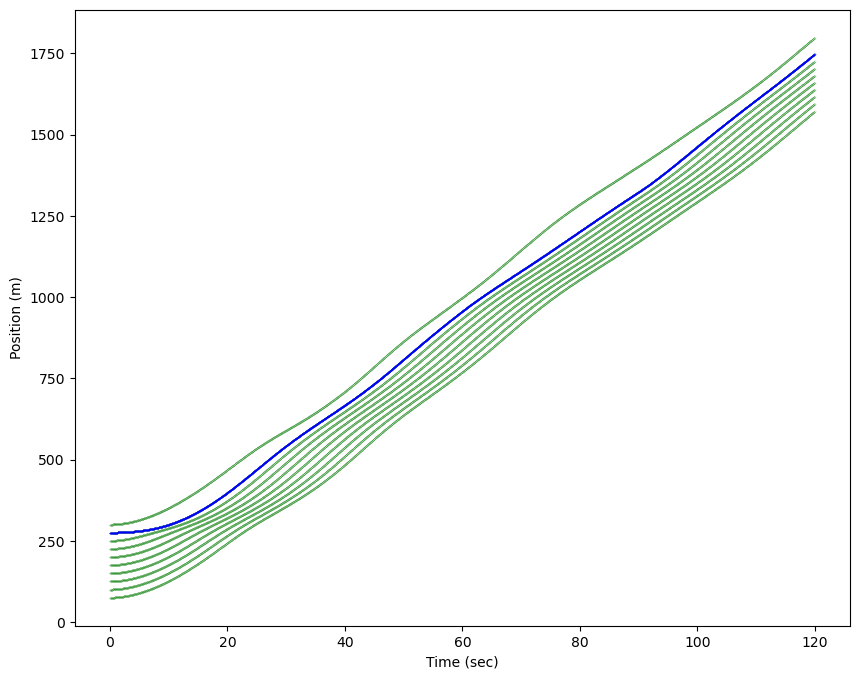

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(t, pos_new, 'g.', markersize=0.3, alpha=0.5, label='All vehicles') # Add label
ax.plot(t, pos_new[:,ACC_ind], 'bs', markersize=0.3, alpha=0.5, label='ACC vehicles') # Add label
# ax.plot(t, pos_new[:,Attack_ind], 'r', markersize=0.3, alpha=0.5, label='ACC vehicles') # Add label

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Position (m)")

# ax.legend() # Add legend


plt.show()


In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))

# Set the start (a) and end (b) times for the shaded area
a = 60# Example start time
b = 90 # Example end time

# Increase marker size for better visibility in the plot
marker_size = 1

# Use a darker shade of green for better visibility and less brightness
ax.plot(t, pos_new % L, '.', color='#008000', markersize=marker_size, label='Human-driven vehicles')
# ax.plot(t, pos_new[:, ACC_ind] %L, 'bs', markersize=marker_size, label='ACC vehicles')
plt.plot(t, pos_new[:, Attack_ind] %L, 'r.', markersize=1, alpha=0.5, label="Attacked Vehicles")

# The attacked vehicles are not labeled and hence not in the legend

ax.set_xlabel("Time (sec)", fontsize=18)  # Increase font size for the axis label
ax.set_ylabel("Position (m)", fontsize=18)  # Increase font size for the axis label

# Increase font size of the numbers on the axes
ax.tick_params(axis='both', labelsize=16)  # Increase font size for the ticks

# Add gridlines to the plot
ax.grid(True)

# Set the legend to show with a larger font, and only for human-driven and ACC vehicles
# Since we have multiple HDVs but want them to appear only once in the legend,
# we can create custom legend entries:
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#008000', marker='.', linestyle='None', markersize=10, label='Human-driven vehicles'),
    # Line2D([0], [0], color='b', marker='.', linestyle='None', markersize=10, label='ACC vehicles'),
        Line2D([0], [0], color='r', marker='.', linestyle='None', markersize=10, label="Attacked Vehicles"),

]
ax.legend(handles=legend_elements, fontsize=16, loc='lower right', markerscale=2)  # Adjust legend position, font size, and marker scale

# Add a title to the plot
ax.set_title("Vehicle Trajectories Over Time", fontsize=20)  # Increase title font size
ax.axvspan(a, b, color='grey', alpha=0.3)


plt.show()



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set figure size
plt.figure(figsize=(12, 9))
# Set the start (a) and end (b) times for the shaded area
a = 60# Example start time
b = 90 # Example end time

# Plot all vehicles in green with alpha for transparency
plt.plot(t, simSpacing, 'g.', markersize=1, alpha=0.5, label="Human Vehicles")

# Plot ACC vehicles in blue with alpha for transparency
# plt.plot(t, simSpacing[:, ACC_ind], 'b.', markersize=1, alpha=0.5, label="ACC Vehicles")
plt.plot(t, simSpacing[:, Attack_ind], 'r.', markersize=1, alpha=0.5, label="Attacked Vehicles")


plt.xlabel("Time (sec)", fontsize=18)
plt.ylabel("Spacing (m)", fontsize=18)

# Increase font size for the tick labels
plt.tick_params(axis='both', labelsize=16)

# Add gridlines to the plot for better readability
plt.grid(True)

# Make top and right spines visible to emulate Matlab's box on
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Create custom legend entries with increased marker size
legend_elements = [
    Line2D([0], [0], color='g', marker='.', linestyle='None', markersize=10, label="Human Vehicles"),
    # Line2D([0], [0], color='b', marker='.', linestyle='None', markersize=10, label="ACC Vehicles"),
    Line2D([0], [0], color='r', marker='.', linestyle='None', markersize=10, label="Attacked Vehicles"),
]
ax.axvspan(a, b, color='grey', alpha=0.3)

# Add a legend to the plot with custom markers
ax.legend(handles=legend_elements, fontsize=16, loc='lower right', markerscale=2)  # Adjust legend position, font size, and marker scale


# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set figure size
plt.figure(figsize=(12, 9))
# Set the start (a) and end (b) times for the shaded area
a = 60# Example start time
b = 90 # Example end time

# Plot all vehicles in green with alpha for transparency
plt.plot(t, simAcc, 'g.', markersize=1, alpha=0.5, label="Human Vehicles")

# Plot ACC vehicles in blue with alpha for transparency
# plt.plot(t, simAcc[:, ACC_ind], 'b.', markersize=1, alpha=0.5, label="ACC Vehicles")

# Plot attacked vehicles in red with alpha for transparency
plt.plot(t, simAcc[:, Attack_ind], 'r.', markersize=1, alpha=0.5, label="Attack Vehicles")

# Set labels with increased font size
plt.xlabel("Time (sec)", fontsize=18)
plt.ylabel("Acceleration (m/s²)", fontsize=18)

# Increase font size for the tick labels
plt.tick_params(axis='both', labelsize=16)

# Add gridlines to the plot for better readability
plt.grid(True)

# Make top and right spines visible to emulate Matlab's box on
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Create custom legend entries with increased marker size
legend_elements = [
    Line2D([0], [0], color='g', marker='.', linestyle='None', markersize=10, label="Human Vehicles"),
    Line2D([0], [0], color='b', marker='.', linestyle='None', markersize=10, label="ACC Vehicles"),
    # Line2D([0], [0], color='r', marker='.', linestyle='None', markersize=10, label="Attacked Vehicles"),
]
ax.axvspan(a, b, color='grey', alpha=0.3)


# Add a legend to the plot with custom markers
ax.legend(handles=legend_elements, fontsize=16, loc='lower right', markerscale=2)  # Adjust legend position, font size, and marker scale



# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set figure size
plt.figure(figsize=(12, 9))

# Set the start (a) and end (b) times for the shaded area
a = 60# Example start time
b = 90 # Example end time

# Plot all vehicles in green with alpha for transparency
plt.plot(t, simFollowVel, 'g.', markersize=1, alpha=0.5, label="Human Vehicles")

# Plot ACC vehicles in blue with alpha for transparency
# plt.plot(t, simFollowVel[:, ACC_ind], 'b.', markersize=1, alpha=0.5, label="ACC Vehicles")

# Plot attacked vehicles in red with alpha for transparency
plt.plot(t, simFollowVel[:, Attack_ind], 'r.', markersize=1, alpha=0.5, label="Attacked Vehicles")

# Set labels with increased font size
plt.xlabel("Time (sec)", fontsize=18)
plt.ylabel("Speed (m/s)", fontsize=18)

# Increase font size for the tick labels
plt.tick_params(axis='both', labelsize=16)

# Add gridlines to the plot for better readability
plt.grid(True)

# Make top and right spines visible to emulate Matlab's box on
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Create custom legend entries with increased marker size
legend_elements = [
    Line2D([0], [0], color='g', marker='.', linestyle='None', markersize=10, label="Human Vehicles"),
    Line2D([0], [0], color='b', marker='.', linestyle='None', markersize=10, label="ACC Vehicles"),
    # Line2D([0], [0], color='r', marker='.', linestyle='None', markersize=10, label="Attacked Vehicles"),
]
ax.axvspan(a, b, color='grey', alpha=0.3)

# Add a legend to the plot with custom markers
ax.legend(handles=legend_elements, fontsize=16, loc='lower right', markerscale=2)  # Adjust legend position, font size, and marker scale

# Display the plot
plt.show()
